# Amazon User Review Quality Prediction Based on Ensemble Learning

## Introduction
When selecting products online, user reviews are often a crucial aspect of the decision-making process. However, the quality of reviews on e-commerce websites can vary greatly, with some reviews being influenced by fake positive or malicious negative feedback, which significantly impacts the shopping experience. Therefore, predicting the quality of reviews has become a topic of increasing importance for e-commerce platforms. By automatically assessing review quality, platforms can avoid displaying low-quality reviews based on the prediction results. In this project, I will use ensemble learning methods to predict the quality of Amazon user reviews in real-world scenarios.


In [1]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB # 导入不同类型的朴素贝叶斯分类器
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # 导入文本特征提取工具：词频和TF-IDF向量化器
from sklearn import preprocessing, tree, ensemble, svm, metrics, calibration  # 导入预处理、决策树、集成方法、支持向量机、评价指标等模块
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import text
from matplotlib import pyplot as plt
from itertools import combinations
from wordcloud import WordCloud # 导入生成词云的工具
from collections import Counter
from textblob import TextBlob # 导入文本情感分析工具
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import math


In [2]:
train_df = pd.read_csv('./data/train.xlsx', sep='\t')
test_df = pd.read_csv('./data/test.xlsx', sep='\t',index_col=False)
train_df.describe()

,reviewerID,asin,overall,votes_up,votes_all,label
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,33359.761865,19973.170866,3.535178,12.387594,18.475850,0.226196
std,30016.804127,14104.410152,1.529742,45.130499,50.149683,0.418371
min,50.000000,0.000000,1.000000,0.000000,5.000000,0.000000
25%,9235.000000,8218.000000,2.000000,4.000000,6.000000,0.000000
50%,22589.000000,17635.000000,4.000000,6.000000,10.000000,0.000000
75%,53170.000000,30875.000000,5.000000,11.000000,18.000000,0.000000
max,123767.000000,50051.000000,5.000000,6084.000000,6510.000000,1.000000


In [3]:
test_df.describe()

,Id,reviewerID,asin,reviewText,overall
count,22418,22417,22417,22417,22417
unique,11210,4585,6492,11209,6
top,0,1053,1907,I REALLY wanted this series but I am in SHOCK ...,5
freq,2,28,56,2,9204


分析数据集

reviewID是用户ID

asin是商品ID

reviewText是评论内容

overall是用户对商品的打分

votes_up是认为评论有用的点赞数

votes_all是该评论得到的总点赞数

label是标签

In [4]:
print('train_df.shape', train_df.shape) 
print('test_df.shape', test_df.shape)

train_df.shape (57039, 7)
test_df.shape (22418, 5)


In [5]:
labels=pd.read_csv("./data/pre_l.csv")
labels._append(labels)

,label
0,0
1,0
2,0
3,0
4,0
...,...
11203,0
11204,0
11205,0
11206,0


In [6]:
test_df['label']=labels
test_df.head()

,Id,reviewerID,asin,reviewText,overall,label
0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1,0.0
1,1,10154,23543,I have to say that this is a work of art for m...,4,0.0
2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3,0.0
3,3,9198,5909,"I love this film...preachy? Well, of course i...",5,0.0
4,4,33252,21214,Even though I previously bought the Gamera Dou...,5,0.0


In [7]:
test_df.drop("Id",axis=1,inplace=True) 
#删除指定的列或行，axis=1按列删，inplace=True直接在原dataframe上操作

In [8]:
# 为训练数据添加一个新列"lenth"，该列存储每个"reviewText"字段中单词的数量
train_df['lenth'] = train_df['reviewText'].map(lambda x:len(x.split(" ")))
# 为训练数据添加一个新列"polarity"，该列存储每个"reviewText"字段中单词的情感极性，GitHub Copilot: 极性值是情感分析中的一个概念，用于表示文本中所表达的情感倾向。
# 通常情况下，极性值为正数表示正面情感，为负数表示负面情感，为0表示中性情感。在这个代码中，使用TextBlob库中的sentiment方法对每个评论文本进行情感分析，得到一个极性值，然后将其添加到DataFrame中的新列`polarity`中。
# 使用了TextBlob库中的sentiment方法，该方法返回一个元组，第一个元素是极性值，第二个元素是主观性值。这里只使用了第一个元素。
train_df['polarity'] = train_df['reviewText'].map(lambda x: TextBlob(x).sentiment[0])  

In [9]:
test_df['lenth'] = test_df['reviewText'].map(lambda x: len(str(x).split(" ")))
test_df['polarity'] = test_df['reviewText'].map(
    lambda x: TextBlob(str(x)).sentiment[0])
test_df.describe()

,label,lenth,polarity
count,11208.000000,22418.000000,22418.000000
mean,0.191827,256.192256,0.138560
std,0.393756,241.774872,0.171641
min,0.000000,1.000000,-1.000000
25%,0.000000,101.000000,0.050509
50%,0.000000,188.000000,0.140980
75%,0.000000,328.000000,0.231422
max,1.000000,5320.000000,1.000000


In [10]:
print("训练集和测试集的比例为：",test_df.shape[0]/train_df.shape[0])    

训练集和测试集的比例为： 0.3930293308087449


In [11]:
# 这个函数的目的是将文本数据向量化。它可以使用CountVectorizer或TfidfVectorizer从sklearn.feature_extraction.text进行操作，取决于method参数的值。向量化之后的特征被返回，同时如果提供了测试数据，测试数据也会被转换。
def get_vectorizer(method, min_df, max_df, max_features, stop_words):
    # 根据指定的方法和参数创建一个文本向量化器
    if method == 'count':
        return CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words) #stop_words='english'，这就意味着它会使用一个内置的英文停用词列表。
    elif method == 'tfidf':
        return TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, ngram_range=(1, 1))

def transform_data(vectorizer, data):
    # 使用指定的向量化器将数据转换为向量表示
    return vectorizer.transform(data).toarray()

def vectorize(train_data, test_data=None, min_df=0.019, max_df=1.0, max_features=5000, stop_words='english', method='tfidf'):
    # 对训练集和测试集进行向量化，并返回向量化后的特征矩阵
    vectorizer = get_vectorizer(method, min_df, max_df, max_features, stop_words)
    vectorizer_model = vectorizer.fit(train_data)
    names = vectorizer_model.get_feature_names_out()
    print('names:')
    print(names)
    features = transform_data(vectorizer, train_data)

    if not test_data.empty:
        test_features = transform_data(vectorizer, test_data)
    else:
        test_features = None

    return names, features, test_features

# 对训练集和测试集的reviewText列进行向量化，并返回向量化后的特征矩阵
names, features, test_features = vectorize(train_df['reviewText'], test_df['reviewText'].apply(lambda x: np.str_(x)))
print('features.shape:')
print(features.shape, test_features.shape if test_features is not None else None)
print('test_features:')
print(test_features[0])
print(test_df['reviewText'][0])
#feature中的每个元素是TF-IDF值 = TF*IDF（TF所在对应文档中词频；IDF整个文档集中的重要率：文档总数/包含该词的文档数，取对数）

names:
['10' '15' '20' '30' '50' 'able' 'absolutely' 'act' 'acted' 'acting'
 'action' 'actor' 'actors' 'actress' 'actual' 'actually' 'add' 'added'
 'addition' 'admit' 'adult' 'adventure' 'age' 'ago' 'agree' 'air'
 'amazing' 'amazon' 'america' 'american' 'animation' 'annoying' 'apart'
 'apparently' 'appear' 'appears' 'appreciate' 'aren' 'art' 'aside' 'ask'
 'aspect' 'attempt' 'attention' 'audience' 'audio' 'available' 'average'
 'away' 'awesome' 'awful' 'baby' 'background' 'bad' 'band' 'based'
 'basically' 'battle' 'beautiful' 'beautifully' 'beauty' 'begin'
 'beginning' 'begins' 'believable' 'believe' 'best' 'better' 'big'
 'biggest' 'bit' 'black' 'blood' 'blu' 'blue' 'body' 'bonus' 'book'
 'books' 'boring' 'bought' 'box' 'boy' 'boys' 'break' 'brilliant' 'bring'
 'brings' 'british' 'brother' 'brothers' 'brought' 'budget' 'bunch'
 'business' 'buy' 'buying' 'called' 'came' 'camera' 'car' 'care' 'career'
 'case' 'cast' 'cause' 'century' 'certain' 'certainly' 'chance' 'change'
 'changed' 'c

10         0.006569
15         0.003169
20         0.004493
30         0.004186
50         0.003194
             ...   
years      0.015687
yes        0.007850
york       0.003320
young      0.011302
younger    0.003019
Length: 870, dtype: float64


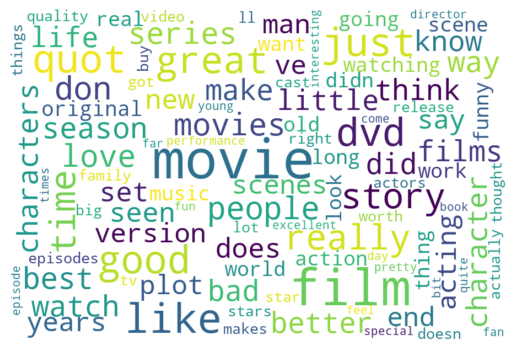

In [12]:
def compute_word_frequencies(features, names):
    """
    计算词频
    """
    df = pd.DataFrame(features, columns=names)
    print(df.mean())
    return dict(df.mean())

def draw_cloud(word_counts, limits_count=100):
    """
    绘制词云，可视化
    """
    my_cloud = WordCloud(
        background_color='white',  # 设置背景颜色  默认是black
        width=900, height=600,
        max_words=limits_count,   # 词云显示的最大词语数量 
        max_font_size=99,         # 设置字体最大值
        min_font_size=16,         # 设置子图最小值
        random_state=50           # 设置随机生成状态，即多少种配色方案
    ).generate_from_frequencies(word_counts)

    plt.imshow(my_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

word_counts = compute_word_frequencies(features, names)
draw_cloud(word_counts)


In [13]:
test_df.fillna(0.0,inplace=True)
test_df.head()

,reviewerID,asin,reviewText,overall,label,lenth,polarity
0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1,0.0,39,0.200000
1,10154,23543,I have to say that this is a work of art for m...,4,0.0,169,0.296491
2,5789,5724,Alien 3 is certainly the most controversal fil...,3,0.0,365,0.016857
3,9198,5909,"I love this film...preachy? Well, of course i...",5,0.0,71,0.333766
4,33252,21214,Even though I previously bought the Gamera Dou...,5,0.0,78,0.246667


In [14]:
test_df[test_df['overall']=='overall']

,reviewerID,asin,reviewText,overall,label,lenth,polarity
11209,reviewerID,asin,reviewText,overall,0.0,1,0.0


In [ ]:
test_df['overall'].iloc[11209]=0.0

In [16]:
X_train = np.concatenate(
    [features, train_df[['overall', 'lenth', 'polarity']]], axis=1)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)

X_test = np.concatenate(
    [test_features, test_df[['overall', 'lenth', 'polarity']]], axis=1)
X_test = preprocessing.MinMaxScaler().fit_transform(X_test.astype(float))

In [17]:
test_df[test_df["overall"].isna()]

,reviewerID,asin,reviewText,overall,label,lenth,polarity


In [18]:
X_train.shape

(57039, 873)

In [19]:
from sklearn import calibration, svm, tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def get_classifiers():
    # 返回一个字典，包含了不同分类器的名称和对应的分类器对象
    return {
        'LinearSVM': calibration.CalibratedClassifierCV(svm.LinearSVC(loss='squared_hinge', dual=False)),
        #因为SVM输出是样本点到决策边界的距离（决策函数值），所以需要CalibratedClassifierCV通过交叉验证来校准为概率
        'DecisionTree': tree.DecisionTreeClassifier(criterion='gini', max_depth=5, splitter='random'),
        'MultBayes': MultinomialNB(alpha=1, fit_prior=True, class_prior=[0.8, 0.2]),
        'Knn': KNeighborsClassifier(n_neighbors=3)
    }

def train_and_evaluate(clf, X_train, y_train):
    # 训练分类器并计算准确率
    clf.fit(X_train[:10000], y_train[:10000])
    predictions = clf.predict(X_train)
    accuracy = accuracy_score(predictions, y_train)
    return accuracy
#可以使用交叉验证更稳健的评估模型（trsin_and_evaluate)：scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
#return scores.mean(), scores.std()
#print(f"Accuracy of {classifier_name}: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
# 获取不同分类器的名称和对应的分类器对象
classifiers = get_classifiers()

# 对每个分类器进行训练和评估
for classifier_name, classifier in classifiers.items():
    accuracy = train_and_evaluate(classifier, X_train, train_df['label'])
    print(f"Accuracy of {classifier_name}: {accuracy}")


Accuracy of LinearSVM: 0.7878644436262908
Accuracy of DecisionTree: 0.7721734252003015
Accuracy of MultBayes: 0.7810971440593278
Accuracy of Knn: 0.7782920457932292


In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 定义函数average，计算结果的平均值
def average(results):
    return np.average(results, axis=1)

# 定义函数weight_average，计算加权结果的平均值
def weight_average(results, weights):
    return np.dot(results, weights) / np.sum(weights)

# 定义函数vote，计算标签的平均值
def vote(labels):
    return np.average(labels, axis=1)

# 定义函数weight_vote，计算加权标签的平均值
def weight_vote(labels, weights):
    return np.dot(labels, weights) / np.sum(weights)

# 定义函数plot_results，绘制ROC曲线和计算AUC和准确率
def plot_results(y, pres, methods, cls_name):
    fig = plt.figure(figsize=(10, 10))
    for idx, method in enumerate(methods): 
        #enumerate(methods)函数迭代methods列表，索引和对应元素for循环
        pre = pres[idx]
        fpr, tpr, thresholds = metrics.roc_curve(y, pre, pos_label=1) #指定1为正类标签
        #thresholds用于区分正类和负类的决策阈值：为很多个阈值然后每个阈值计算出对应的tpr、fpr画出ROC图
        #虽然pre为概率，但roc_curve会使用一系列阈值将概率转化为二分类结果，从而计算不同阈值下的tpr与fpr
        #fpr负类被分为正类的比例；TPR正类被正确分为正类的比例（也是召回率）
        # 计算ROC曲线
        plt.subplot(2, 2, idx+1)
        plt.plot(fpr, tpr, lw=2)
        auc = metrics.auc(fpr, tpr)
        # 计算AUC
        pre[pre >= 0.5], pre[pre < 0.5] = 1, 0
        acc = accuracy_score(pre, y)
        # 计算准确率
        plt.title('Method: %s    Auc: %.2f    Acc: %.2f' % (method, auc, acc))
    plt.suptitle('Classifier: '+str(cls_name))

# 定义函数weight，内部调用plot_results()计算加权结果并绘制ROC曲线和计算AUC和准确率
def weight(results, labels, weights, y, cls_name, vote_thr=0.5):
    results, labels, weights = np.array(results).T, np.array(labels).T, np.array(weights)
    #methods是不同的集成方法：怎么算各分类器的平均结果（平均/加权平均）
    methods = ['average', 'weight-average', 'vote', 'weight-vote']
    pres = [average(results), weight_average(results, weights), vote(labels), weight_vote(labels, weights)]

    plot_results(y, pres, methods, cls_name)


In [22]:
import numpy as np
import random
import math
from sklearn.metrics import accuracy_score

import random
import numpy as np

def draw_samples(datas, sample_size, feature_size):
    # 从数据集中随机选择一些样本和特征
    sample_indices = random.sample(range(datas[0].shape[0]), sample_size)
    feature_indices = random.sample(range(datas[0].shape[1]), feature_size)
    return sample_indices, feature_indices 

def fit_and_predict(clf, datas, sample_indices, feature_indices):
    # 使用分类器对样本进行拟合和预测
    clf.fit(datas[0][sample_indices][:, feature_indices], datas[1][sample_indices])
    predictions = np.array([p[1] for p in clf.predict_proba(datas[2][:, feature_indices])])
    #.predict_proba()专门用于返回预测的概率，对于二分类问题，返回样本点数行，两列内容（两类的分别概率）
    #p[0]返回属于类别0的概率
    return predictions

def create_labels(predictions, threshold):
    # 根据预测概率和阈值创建标签
    labels = predictions.copy() #创建与个副本赋值到labels中，防止更改labels时也改了predictions
    labels[labels > threshold], labels[labels <= threshold] = 1, 0
    return labels

In [1]:
#bagging和adaboost都是使用同类型的多个模型（即同质模型）来训练；异质集成模型Stacking和Voting
def bagging(base_estimators, datas, n_estimators=10, max_samples=0.1, max_features=0.5):
    # 定义bagging函数，接受基分类器、数据集、基分类器数量、样本采样比例和特征采样比例作为参数
    assert (n_estimators>0 and max_samples>0 and max_features>0)
    # 断言基分类器数量、样本采样比例和特征采样比例均大于0
    #断言用于测试一个条件，并在条件为假时引发异常（确保传入函数参数满足某些前置条件）
    results, labels, weights = [], [], []
    # 初始化结果、标签和权重列表
    sample_size, feature_size = int(max_samples * datas[0].shape[0]), int(max_features * datas[0].shape[1])
    # 计算样本数量和特征数量
    for clf in base_estimators:
        # 对于每个基分类器
        for _ in range(n_estimators):
            # 对于每个基分类器，重复n_estimators次
            sample_indices, feature_indices = draw_samples(datas, sample_size, feature_size)
            # 从数据集中随机选择一些样本和特征
            predictions = fit_and_predict(clf, datas, sample_indices, feature_indices)
            # 使用分类器对样本进行拟合和预测
            results.append(predictions)
            # 将预测结果添加到结果列表中
            labels.append(create_labels(predictions, np.sort(predictions)[int(0.85 * len(predictions))]))
            # 根据预测概率和阈值创建标签，并将标签添加到标签列表中
            weights.append(accuracy_score(labels[-1], datas[3]))
            # 计算标签的准确率，并将准确率添加到权重列表中
            #labels[-1]指每次都计算最新添加的预测标签与真实标签的准确率
    return results, labels, weights
    # 返回结果、标签和权重列表

def adaboost(base_estimator, datas, n_estimators=30, learning_rate=1.0, max_samples=0.05, max_features=1.0):
    # 定义adaboost函数，接受基分类器、数据集、基分类器数量、学习率、样本采样比例和特征采样比例作为参数
    assert (n_estimators > 0 and max_samples > 0 and max_features > 0)
    # 断言基分类器数量、样本采样比例和特征采样比例均大于0
    results, labels, weights = [], [], []
    # 初始化结果、标签和权重列表
    sample_size, feature_size = int(max_samples * datas[0].shape[0]), int(max_features * datas[0].shape[1])
    # 计算样本数量和特征数量
    clf = base_estimator
    # 初始化分类器
    sample_weights = np.array([1/datas[0].shape[0] for _ in range(datas[0].shape[0])])
    # 初始化样本权重
    for _ in range(n_estimators):
        # 对于每个基分类器，重复n_estimators次
        sample_indices = random.choices(range(datas[0].shape[0]), weights=sample_weights, k=sample_size)
        # 根据样本权重从数据集中随机选择一些样本：对于 AdaBoost 算法，优先选择加权抽样的样本，因此 random.choices 方法非常合适。
        feature_indices = draw_samples(datas, sample_size, feature_size)
        # 从数据集中随机选择一些(样本从上一个中获取了)和特征
        predictions = fit_and_predict(clf, datas, sample_indices, feature_indices)
        # 使用分类器对样本进行拟合和预测
        misclassified = np.array(clf.predict(datas[0][sample_indices, :][:, feature_indices])) ^ datas[1][sample_indices]
        # 计算分类错误的样本：运用异或运算符^计算分类错误的样本：相同为0，不同为1.
        error = np.sum(sample_weights[sample_indices][misclassified == 1])
        # 计算分类错误的样本的权重和
        if error > 0.5:
            print('ERROR more than half.')
            break
        # 如果分类错误的样本权重和大于0.5，则退出循环：Adaboost假设弱分类器的错误率小于0.5（大于0.5说明该弱分类器比随即猜测还差，继续训练无意义）
        sample_weights[sample_indices][misclassified == 1] *= learning_rate * error / (1 - error)
        # 更新分类错误的样本的权重：更新公式，error / (1 - error)：错误样本的权重增加比例；learning_rate：控制权重调整的步长
        sample_weights /= np.sum(sample_weights)
        # 归一化样本权重：样本权重除以权重总和保证权重之和为1
        results.append(predictions)
        # 将预测结果添加到结果列表中
        labels.append(create_labels(predictions, np.sort(predictions)[int(0.8 * len(predictions))]))
        # 根据预测概率和阈值创建标签，并将标签添加到标签列表中
        weights.append(1/2 * math.log((1 - error) / error))
        # 计算基分类器的权重：Adaboost中的基分类器的权重计算公式
    return results, labels, weights
    # 返回结果、标签和权重列表

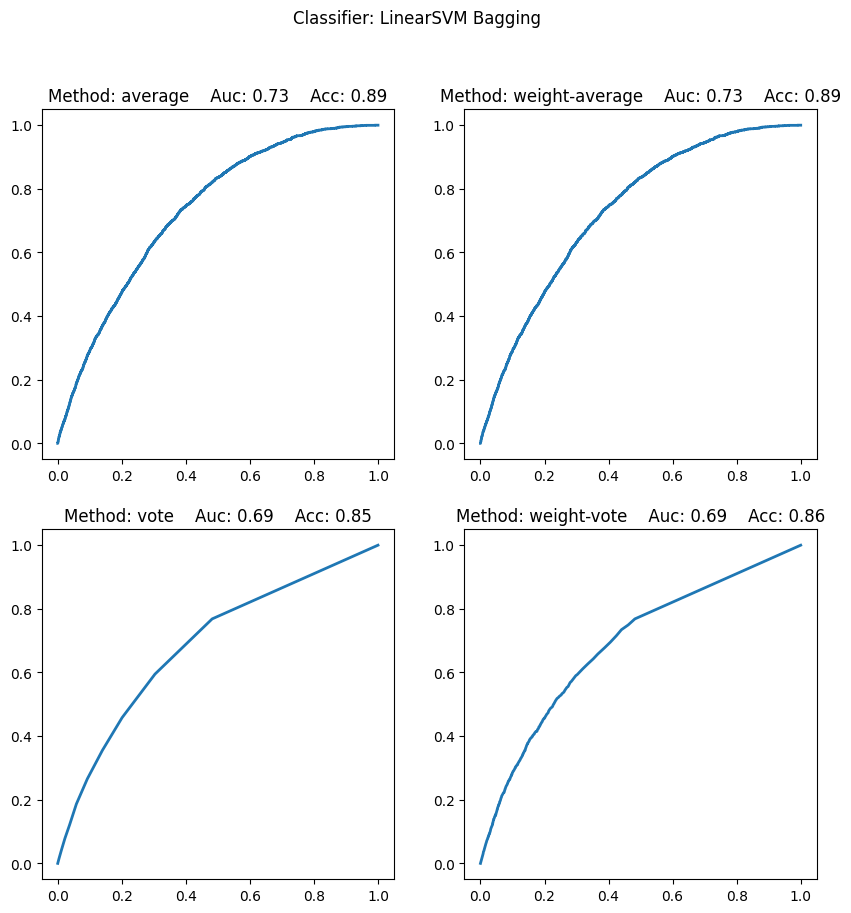

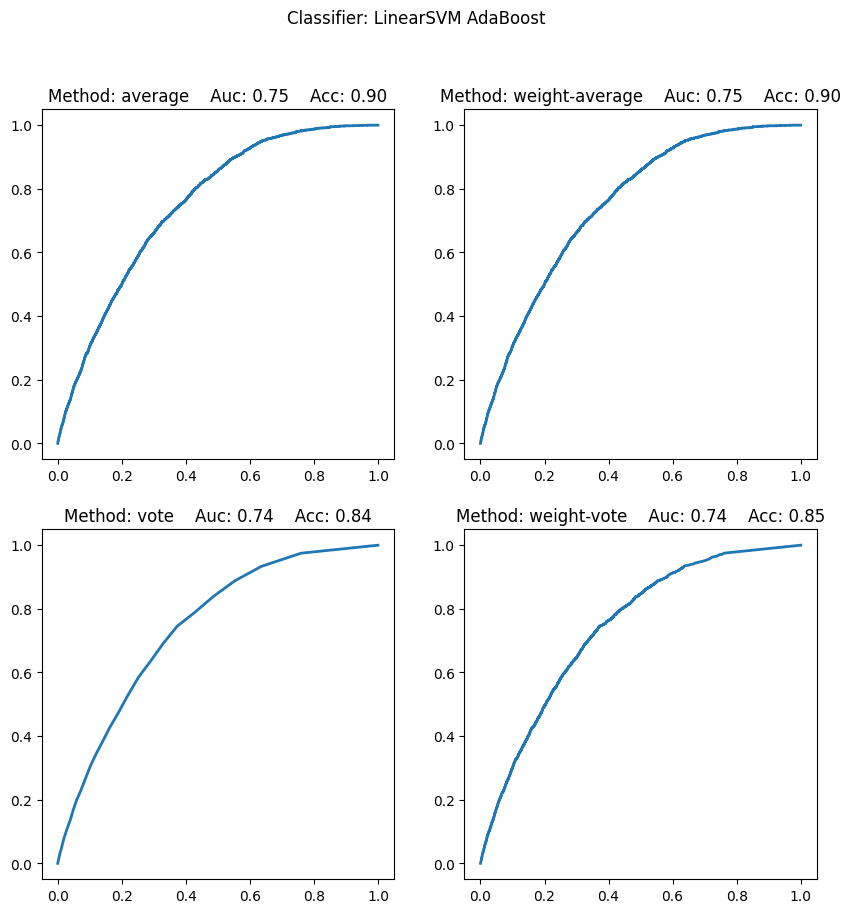

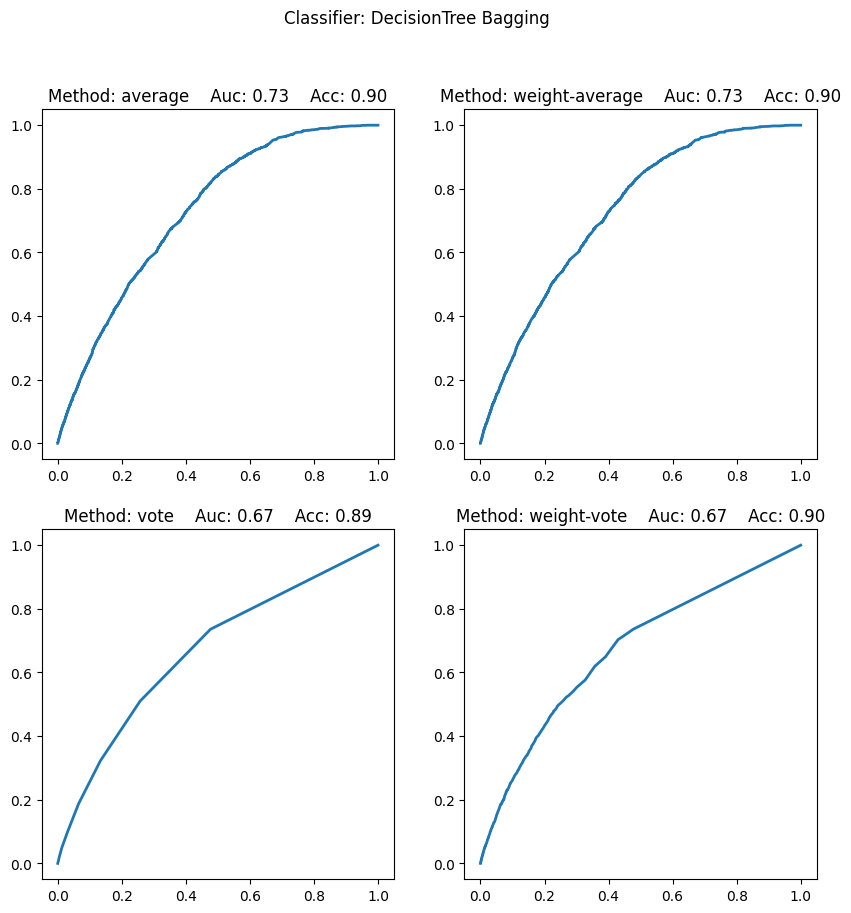

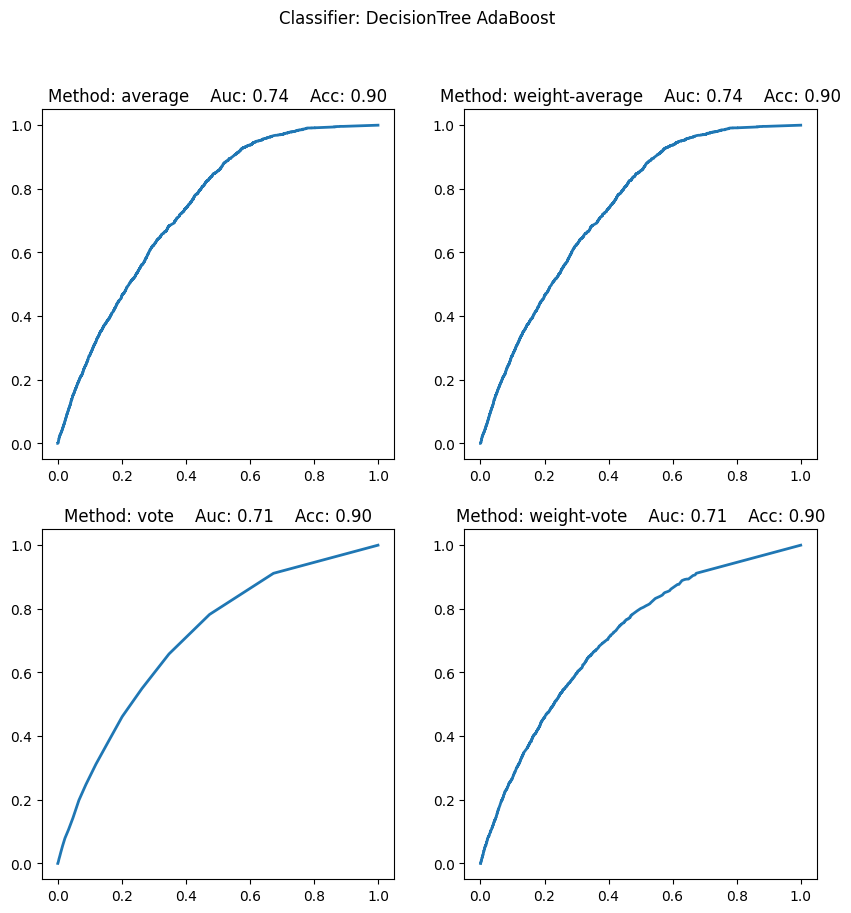

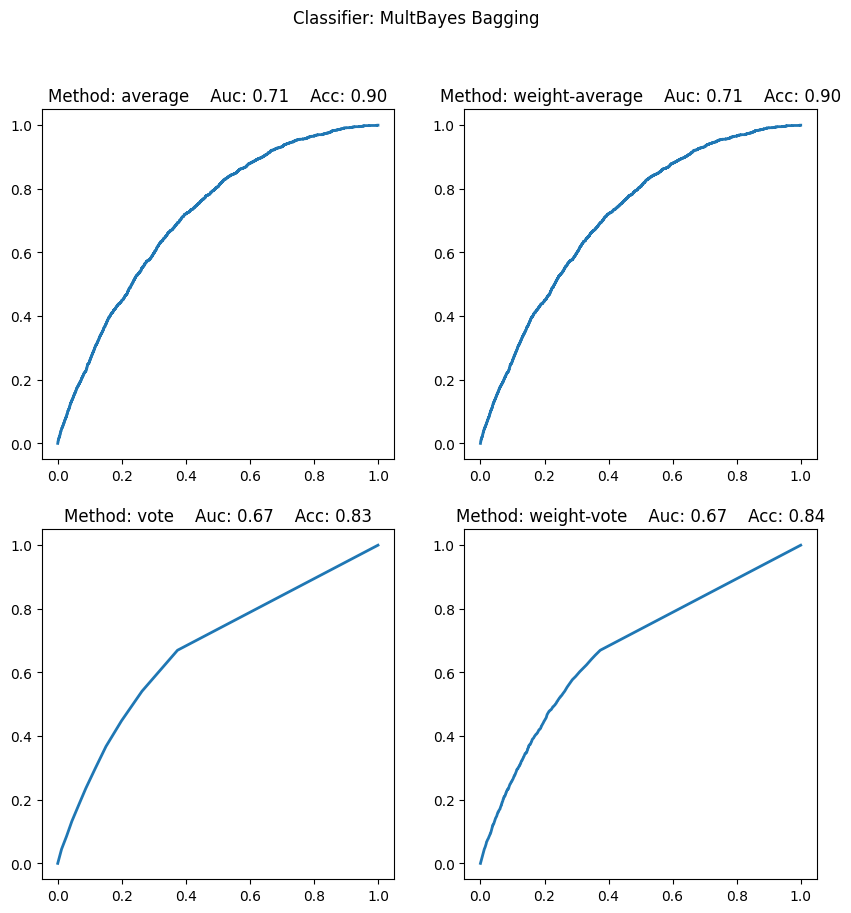

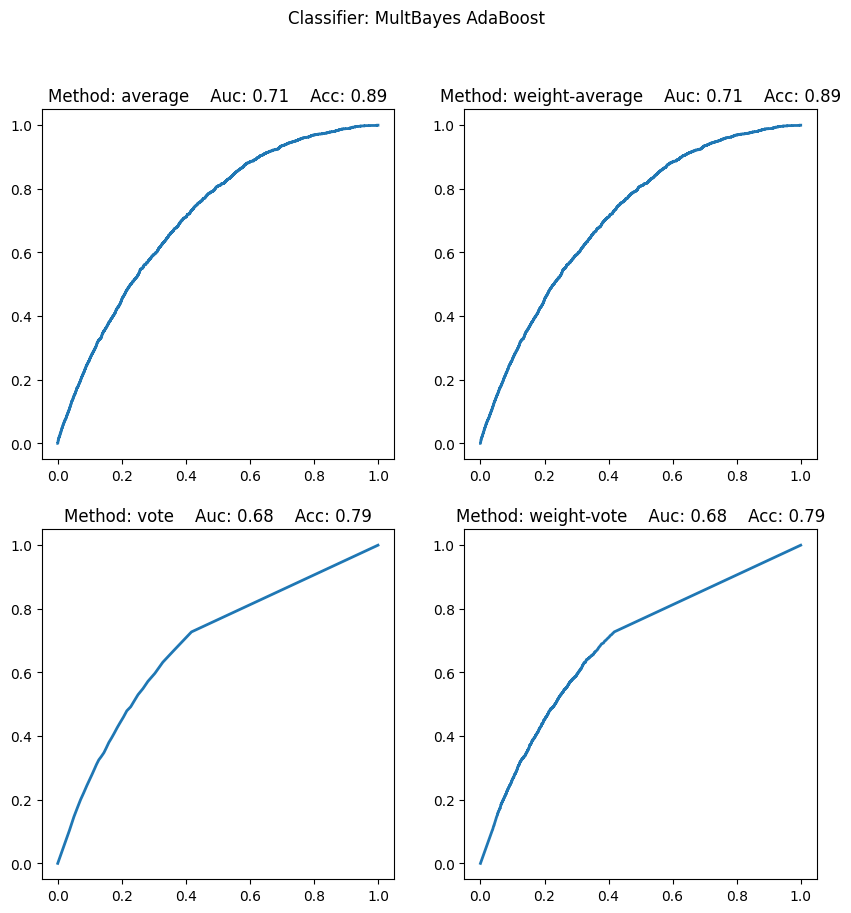

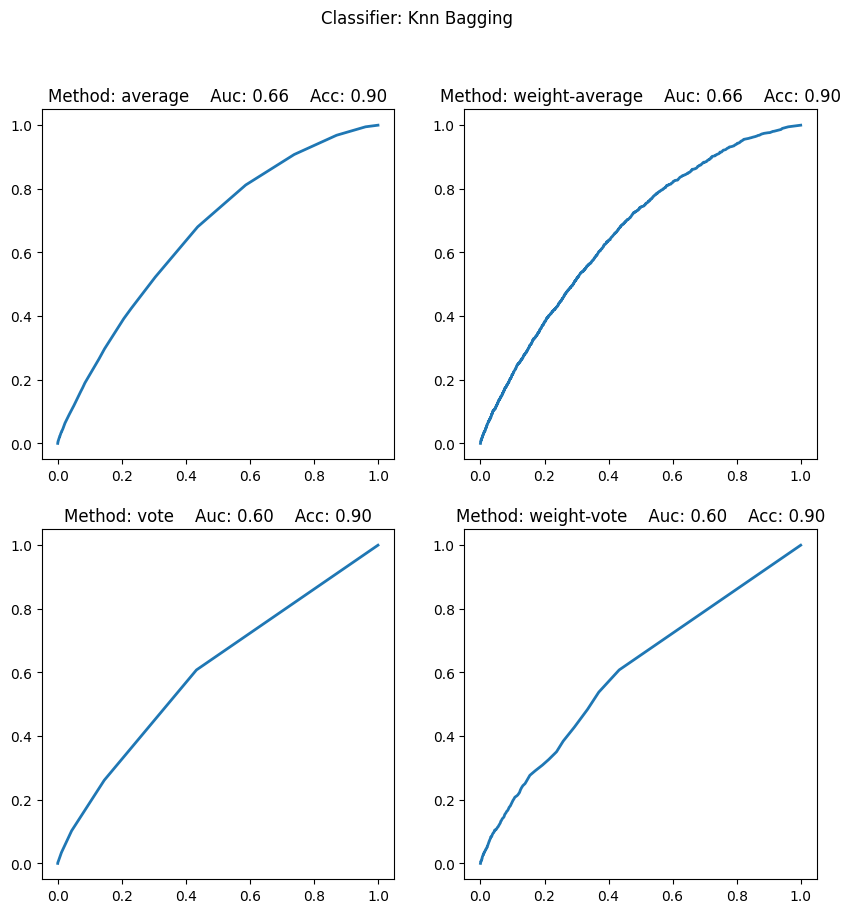

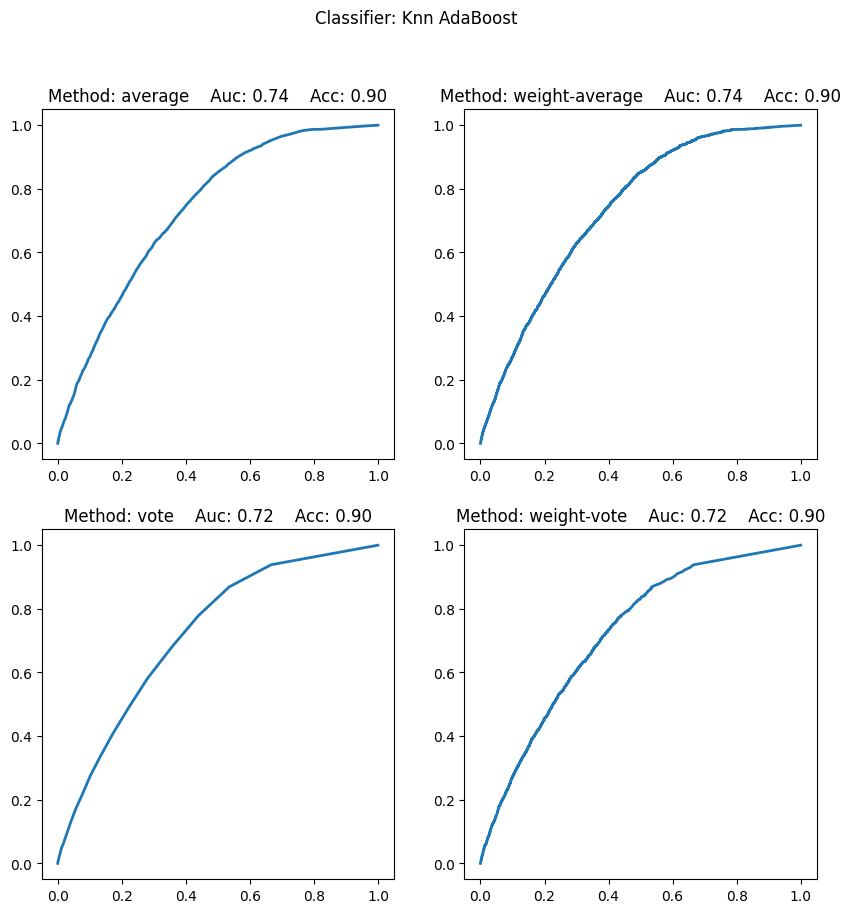

In [24]:
# Prepare the data
y_train = train_df['label']
y_test = test_df['label']

# Base estimators
base_estimators = get_classifiers()

# Train and evaluate ensemble models
for name, clf in base_estimators.items():
    # Data format: [X_train, y_train, X_test, y_test]
    datas = [X_train, y_train, X_test, y_test]
    
    # Bagging
    results_bagging, labels_bagging, weights_bagging = bagging(clf, datas, n_estimators=10, max_samples=0.1, max_features=0.5)
    weight(results_bagging, labels_bagging, weights_bagging, y_test, name + ' Bagging')
    
    # AdaBoost
    results_adaboost, labels_adaboost, weights_adaboost = adaboost(clf, datas, n_estimators=30, learning_rate=1.0, max_samples=0.05, max_features=1.0)
    weight(results_adaboost, labels_adaboost, weights_adaboost, y_test, name + ' AdaBoost')


In [25]:
# Define a function to evaluate the model
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy}")

# Base estimators
base_estimators = get_classifiers()

# Train and evaluate ensemble models
for name, clf in base_estimators.items():
    # Data format: [X_train, y_train, X_test, y_test]
    datas = [X_train, y_train, X_test, y_test]

    # Bagging
    results_bagging, labels_bagging, weights_bagging = bagging([clf], datas, n_estimators=10, max_samples=0.1, max_features=0.5)
    y_pred_bagging = np.average(results_bagging, axis=0, weights=weights_bagging)  # average the results of all the bagging classifiers
    y_pred_bagging = (y_pred_bagging > 0.5).astype(int)
    print(f"Evaluation of Bagging with {name}:")
    evaluate_model(y_test, y_pred_bagging)

    # AdaBoost
    results_adaboost, labels_adaboost, weights_adaboost = adaboost(clf, datas, n_estimators=30, learning_rate=1.0, max_samples=0.05, max_features=1.0)
    y_pred_adaboost = np.average(results_adaboost, axis=0, weights=weights_adaboost)  # average the results of all the adaboost classifiers
    y_pred_adaboost = (y_pred_adaboost > 0.5).astype(int)
    print(f"Evaluation of AdaBoost with {name}:")
    evaluate_model(y_test, y_pred_adaboost)


Evaluation of Bagging with LinearSVM:
Model accuracy: 0.8959764474975466
Evaluation of AdaBoost with LinearSVM:
Model accuracy: 0.9014185029886698
Evaluation of Bagging with DecisionTree:
Model accuracy: 0.9035596395753412
Evaluation of AdaBoost with DecisionTree:
Model accuracy: 0.9034704255508966
Evaluation of Bagging with MultBayes:
Model accuracy: 0.9040057096975644
Evaluation of AdaBoost with MultBayes:
Model accuracy: 0.8903559639575341
Evaluation of Bagging with Knn:
Model accuracy: 0.9036488535997859
Evaluation of AdaBoost with Knn:
Model accuracy: 0.9009724328664466
